In [1]:
import sys
sys.path.append('/home/a202192010/2024/Paper_brain_tumor/models') # put the path to models folder

print(sys.path)

['/home/a202192010/2024/Paper_brain_tumor', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/a202192010/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/home/a202192010/2024/Paper_brain_tumor/models']


In [21]:
import tensorflow as tf
import os
import numpy as np

np.set_printoptions(threshold=np.inf) # NumPy 설정
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # CUDA 가시성 설정 (GPU 사용시 필요)

# GPU 메모리 구성 설정 (GPU 사용시 필요)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # TensorFlow 2.x에서는 set_memory_growth 대신에 메모리 할당 옵션을 설정하는 코드
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

### data_load

train_images : (3906, 240, 240, 4)
train_labels : (3906, 240, 240)
val_images   : (1302, 240, 240, 4)
val_labels   : (1302, 240, 240)
test_images  : (1302, 240, 240, 4)
test_labels  : (1302, 240, 240)


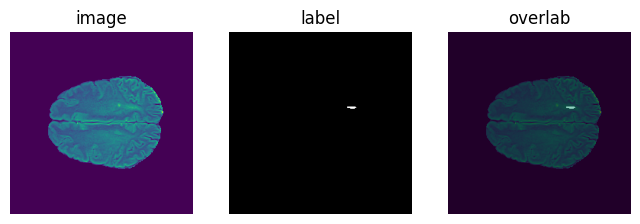

In [3]:
from dataloader import DataProcessor

# 데이터 경로 설정
train_path = '/home/a202192010/2024/Paper_brain_tumor/dataset/basedata/'
val_path = '/home/a202192010/2024/Paper_brain_tumor/dataset/basedata/'
test_path = '/home/a202192010/2024/Paper_brain_tumor/dataset/basedata/'

# DataProcessor 클래스 인스턴스 생성
data_processor = DataProcessor(train_path, val_path, test_path)

# 데이터 로드 및 처리
data_processor.load_and_process_data()

# 데이터셋의 크기 출력
data_processor.print_shapes()

# 첫 번째 테스트 이미지 시각화
data_processor.visualize_image(num=0)

In [4]:
train_images = data_processor.train_images
train_labels = data_processor.train_labels
val_images = data_processor.val_images
val_labels = data_processor.val_labels
test_images = data_processor.test_images
test_labels = data_processor.test_labels

### 데이터 샘플링

In [18]:
def process_datasets(train_images, train_labels, val_images, val_labels, test_images, test_labels, threshold, fraction):
    train_processor = ImageProcessor(train_images, train_labels)
    train_images, train_labels = train_processor.select_images(threshold)
    train_images, train_labels = train_processor.sample_data(fraction)
    
    val_processor = ImageProcessor(val_images, val_labels)
    val_images, val_labels = val_processor.select_images(threshold)
    val_images, val_labels = val_processor.sample_data(fraction)
    
    test_processor = ImageProcessor(test_images, test_labels)
    test_images, test_labels = test_processor.select_images(threshold)
    test_images, test_labels = test_processor.sample_data(fraction)
    
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)


In [13]:
import numpy as np
from image_processor import ImageProcessor

threshold = 500
fraction = 0.4

(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = process_datasets(
    train_images, train_labels, val_images, val_labels, test_images, test_labels, threshold, fraction
)

In [14]:
train_images.shape

(626, 240, 240, 4)

In [15]:
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Validation labels shape: {val_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")


Train images shape: (626, 240, 240, 4)
Train labels shape: (626, 240, 240)
Validation images shape: (521, 240, 240, 4)
Validation labels shape: (521, 240, 240)
Test images shape: (521, 240, 240, 4)
Test labels shape: (521, 240, 240)


### categorical-label

In [16]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels, num_classes=4) # 레이블 원핫 인코딩
val_labels = to_categorical(val_labels, num_classes=4)

### model

In [19]:
from res_unet_2plus import f_model ## model

input_shape = (240, 240, 4) # change channel by the shape of dataset
num_classes = 4
model = f_model(input_shape, num_classes)
model.summary()

2024-05-30 09:31:16.926184: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38357 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:86:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 240, 240, 16)         592       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 240, 240, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 240, 240, 16)         0         ['batch_normalization[0][0

                                                                                                  
 add_2 (Add)                 (None, 60, 60, 64)           0         ['conv2d_7[0][0]',            
                                                                     'conv2d_8[0][0]']            
                                                                                                  
 global_average_pooling2d_2  (None, 64)                   0         ['add_2[0][0]']               
  (GlobalAveragePooling2D)                                                                        
                                                                                                  
 reshape_2 (Reshape)         (None, 1, 1, 64)             0         ['global_average_pooling2d_2[0
                                                                    ][0]']                        
                                                                                                  
 dense_4 (

                                                                                                  
 conv2d_18 (Conv2D)          (None, 30, 30, 256)          590080    ['activation_8[0][0]']        
                                                                                                  
 add_5 (Add)                 (None, 30, 30, 256)          0         ['max_pooling2d[0][0]',       
                                                                     'conv2d_18[0][0]']           
                                                                                                  
 batch_normalization_13 (Ba  (None, 30, 30, 256)          1024      ['add_5[0][0]']               
 tchNormalization)                                                                                
                                                                                                  
 activation_9 (Activation)   (None, 30, 30, 256)          0         ['batch_normalization_13[0][0]
          

                                                                    ']                            
                                                                                                  
 conv2d_25 (Conv2D)          (None, 60, 60, 128)          147584    ['activation_14[0][0]']       
                                                                                                  
 multiply_5 (Multiply)       (None, 60, 60, 128)          0         ['conv2d_25[0][0]',           
                                                                     'add_6[0][0]']               
                                                                                                  
 up_sampling2d_1 (UpSamplin  (None, 120, 120, 128)        0         ['multiply_5[0][0]']          
 g2D)                                                                                             
                                                                                                  
 concatena

 concatenate_2 (Concatenate  (None, 240, 240, 80)         0         ['up_sampling2d_2[0][0]',     
 )                                                                   'add[0][0]']                 
                                                                                                  
 global_average_pooling2d_5  (None, 80)                   0         ['concatenate_2[0][0]']       
  (GlobalAveragePooling2D)                                                                        
                                                                                                  
 reshape_5 (Reshape)         (None, 1, 1, 80)             0         ['global_average_pooling2d_5[0
                                                                    ][0]']                        
                                                                                                  
 dense_10 (Dense)            (None, 1, 1, 10)             800       ['reshape_5[0][0]']           
          

### fit

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy

histories = []
model_paths = {}

loss_fn = CategoricalCrossentropy()

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
history= model.fit(train_images, train_labels, epochs=50, batch_size=16, validation_data=(val_images, val_labels))
histories.append(history.history)

Epoch 1/50


#### test data evaluate

In [ ]:
test_label_e = to_categorical(test_labels, num_classes=4)
loss, acc = model.evaluate(test_images, test_label_e, verbose=2)

In [ ]:
import matplotlib.pyplot as plt

plot_target = ['loss', 'val_loss']
plt.figure(figsize=(8,5))
for each in plot_target:
    plt.plot(history.history[each], label = each)
plt.legend(), plt.grid(), plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = model.predict(test_images)

y_true = np.argmax(test_label_e, axis=3)
y_pred = np.argmax(y_pred, axis=3)

y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

conf_mat = confusion_matrix(y_true_flat, y_pred_flat)

### results

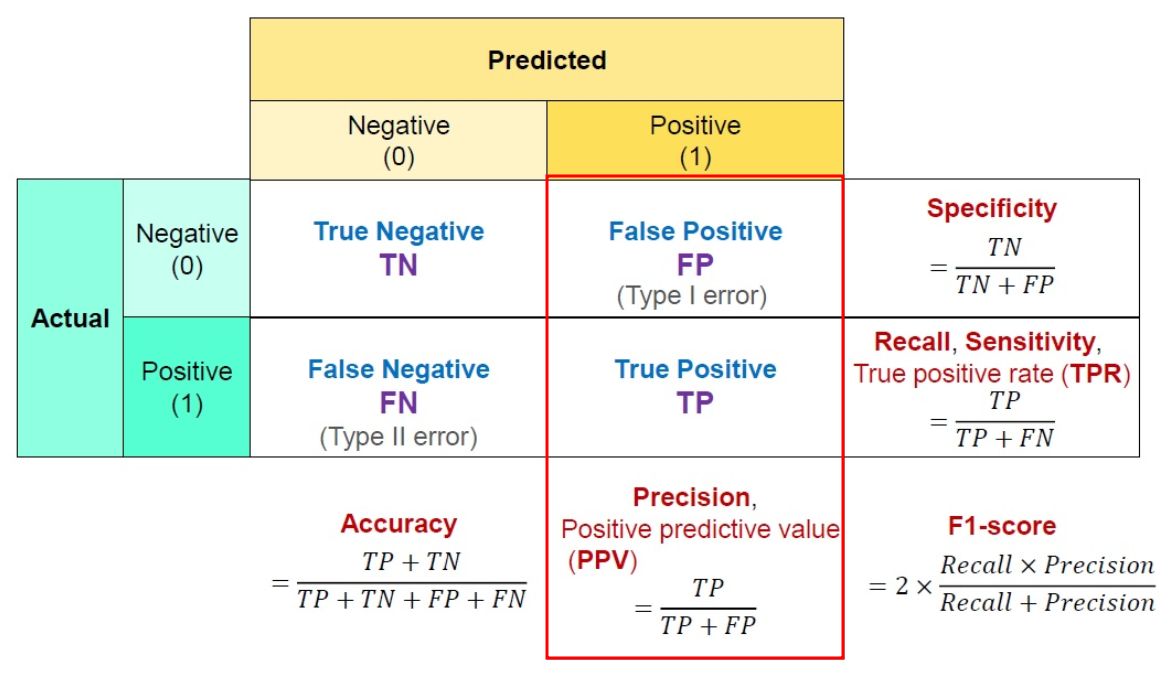

In [ ]:
import pandas as pd
from metrix import sensitivity,specificity,F1_score,precision

Sensitivity = sensitivity(conf_mat, 4)
Specificity = specificity(conf_mat, 4)
f1 = F1_score(conf_mat, 4)
Positive_predictive_value = precision(conf_mat, 4)

data = {'Sensitivity': Sensitivity,
        'Specificity': Specificity,
        'F1 Score': f1,
        'Precision': Positive_predictive_value}

df = pd.DataFrame(data, index=[0,1,2,3])
df.loc['Col Ave'] = df.mean()

df

In [ ]:
from testvisual import visual_num

for i in range(5):
    print(i + 1, ")")
    visual_num(i, test_images, test_labels, model)

In [ ]:
model.save('brain_tumor_base.h5')